In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [3]:
data_directory_pickle = os.path.join('..','data','pickle')
img_directory= os.path.join( '..','images')

dataset = os.path.join(data_directory_pickle,'health_data.pkl')

In [4]:
df = pd.read_pickle(dataset)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44918 entries, 0 to 44917
Data columns (total 9 columns):
business_id        44918 non-null object
review_id          44918 non-null object
health_business    44918 non-null object
name               44918 non-null object
stars              44918 non-null int64
text               44918 non-null object
processed          44918 non-null object
polarity           44918 non-null float64
subjectivity       44918 non-null float64
dtypes: float64(2), int64(1), object(6)
memory usage: 3.1+ MB


In [6]:
df.head(2)

,business_id,review_id,health_business,name,stars,text,processed,polarity,subjectivity
0,2hpi6pXIFf0taDIYCoNIuw,4ar9LmGU4rQ3vXFj325HCg,urgent care,Healthcare Partner,1,If your aim is to waste hours upon hours of yo...,if your aim is to waste hours upon hours of yo...,-0.062605,0.532773
1,2hpi6pXIFf0taDIYCoNIuw,mZo59NzNBPr9RegkzjIGVA,urgent care,Healthcare Partner,5,Memorial Day Weekend.. I cannot Thank Doctor ...,memorial day weekend i cannot thank doctor shu...,0.281250,0.553125


In [7]:
df.stars.value_counts()

5    21365
1    15753
4     3279
2     2778
3     1743
Name: stars, dtype: int64

In [8]:
df.health_business.value_counts()

hospital              8247
family practice       6869
urgent care           6637
obstetrician          5846
chiropractors         5739
diagnostic service    5011
internal medicine     3577
physical therapy      1818
mental health         1174
Name: health_business, dtype: int64

## combine 1& 2 star values and 5

In [9]:
data = df.ix[np.where((df.stars<=2)|(df.stars==5))]

In [10]:
data.stars.value_counts()

5    21365
1    15753
2     2778
Name: stars, dtype: int64

In [11]:
data['review'] = np.where((data.stars<=2),'bad_review','good_review')

In [12]:
data.review.value_counts()

good_review    21365
bad_review     18531
Name: review, dtype: int64

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39896 entries, 0 to 44917
Data columns (total 10 columns):
business_id        39896 non-null object
review_id          39896 non-null object
health_business    39896 non-null object
name               39896 non-null object
stars              39896 non-null int64
text               39896 non-null object
processed          39896 non-null object
polarity           39896 non-null float64
subjectivity       39896 non-null float64
review             39896 non-null object
dtypes: float64(2), int64(1), object(7)
memory usage: 3.3+ MB


In [14]:
data.head(2)

,business_id,review_id,health_business,name,stars,text,processed,polarity,subjectivity,review
0,2hpi6pXIFf0taDIYCoNIuw,4ar9LmGU4rQ3vXFj325HCg,urgent care,Healthcare Partner,1,If your aim is to waste hours upon hours of yo...,if your aim is to waste hours upon hours of yo...,-0.062605,0.532773,bad_review
1,2hpi6pXIFf0taDIYCoNIuw,mZo59NzNBPr9RegkzjIGVA,urgent care,Healthcare Partner,5,Memorial Day Weekend.. I cannot Thank Doctor ...,memorial day weekend i cannot thank doctor shu...,0.281250,0.553125,good_review


# Split data

In [15]:
X = data.processed
y = data.review

# import libraries

In [16]:
from __future__ import print_function

from pprint import pprint
import time
import logging

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,recall_score,precision_score

## train test split

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [18]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),#stop_words="english",
                                   max_features=50000,
                                   max_df=0.5)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)


mn_tfidf_clf = MultinomialNB(alpha=0.5)
mn_tfidf_clf.fit(tfidf_train, y_train)
pred = mn_tfidf_clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.962


In [19]:
# examine class distribution
print(y_test.value_counts())

good_review    7048
bad_review     6118
Name: review, dtype: int64


In [20]:
null_accuracy = y_test.value_counts().head(1) / len(y_test)
print('Null accuracy:', null_accuracy)

Null accuracy: good_review    0.535318
Name: review, dtype: float64


In [21]:
y_pred_prob = mn_tfidf_clf.predict_proba(tfidf_test)[:, 1]

In [22]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9933489045740246

In [23]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

  bad_review       0.95      0.97      0.96      6118
 good_review       0.97      0.95      0.96      7048

   micro avg       0.96      0.96      0.96     13166
   macro avg       0.96      0.96      0.96     13166
weighted avg       0.96      0.96      0.96     13166



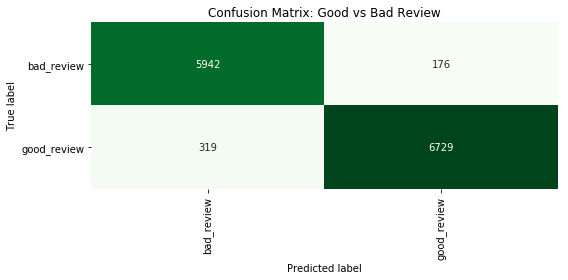

In [24]:
title = 'Confusion Matrix: Good vs Bad Review'
labels =list(np.unique(y))
cm = confusion_matrix(y_test, pred,labels=labels)
plt.figure(figsize = (8,4))
g = sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap="Greens",xticklabels=True,yticklabels=True)
g.set_yticklabels(labels, rotation =0)
g.set_xticklabels(labels, rotation =90)
plt.title(title)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
#plt.savefig('{}/{}.png'.format(img_directory,title.replace(" ", "_")))
plt.savefig('{}/{}.svg'.format(img_directory,title.replace(" ", "_"),dpi=1200))

plt.show()

## health_business

In [25]:
df.health_business.value_counts()

hospital              8247
family practice       6869
urgent care           6637
obstetrician          5846
chiropractors         5739
diagnostic service    5011
internal medicine     3577
physical therapy      1818
mental health         1174
Name: health_business, dtype: int64

In [26]:
X2= df.processed
y2 = df.health_business.values

# train test split

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.33, random_state=42)

In [28]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),
                                   stop_words='english',
                                   max_features=10000,
                                   max_df=0.6)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)


mn_tfidf_clf = MultinomialNB(alpha=1)
mn_tfidf_clf.fit(tfidf_train, y_train)
pred = mn_tfidf_clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.598


In [29]:
print(classification_report(y_test, pred))

                    precision    recall  f1-score   support

     chiropractors       0.71      0.86      0.78      1882
diagnostic service       0.67      0.60      0.64      1625
   family practice       0.44      0.61      0.51      2233
          hospital       0.51      0.63      0.56      2715
 internal medicine       0.85      0.44      0.58      1195
     mental health       1.00      0.03      0.06       374
      obstetrician       0.75      0.63      0.68      1950
  physical therapy       0.91      0.17      0.29       586
       urgent care       0.58      0.59      0.59      2263

         micro avg       0.60      0.60      0.60     14823
         macro avg       0.71      0.51      0.52     14823
      weighted avg       0.64      0.60      0.59     14823



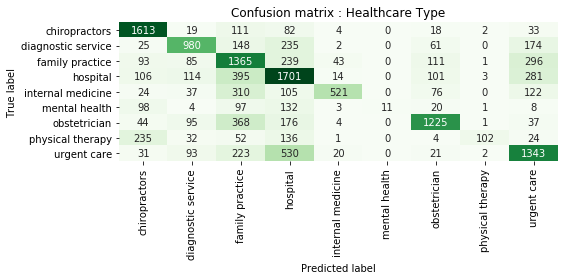

In [30]:
title = 'Confusion matrix : Healthcare Type'
labels =list(np.unique(y2))
cm = confusion_matrix(y_test, pred,labels=labels)
plt.figure(figsize = (8,4))
g = sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap="Greens",xticklabels=True,yticklabels=True)
g.set_yticklabels(labels, rotation =0)
g.set_xticklabels(labels, rotation =90)
plt.title(title)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
#plt.savefig('{}/{}.png'.format(img_directory,title.replace(" ", "_")))
plt.savefig('{}/{}.svg'.format(img_directory,title.replace(" ", "_"),dpi=1200))
plt.show()

## Display Feature importance

In [31]:
feature_names = np.array(tfidf_vectorizer.get_feature_names())
sorted_coef_index = mn_tfidf_clf.coef_[0].argsort()

In [32]:
print('Lowest 10 Coef:')
for i in feature_names[sorted_coef_index][:10]:
    print (i)

Lowest 10 Coef:
zocdoc
month advance
month appointment
month check
months advance
moss
mountain vista
chit
nagel
nagy


In [33]:
print('Highest 10 Coef:')
for i in feature_names[sorted_coef_index][-10:]:
    print (i)

Highest 10 Coef:
neck
best
adjustment
recommend
great
chiropractic
number
chiropractor
pain
doctor
